In [1]:
import numpy as np
import pandas as pd
import librosa.display
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

ModuleNotFoundError: No module named 'librosa'

In [2]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

'git' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
n_mfcc = 20   # number of MFCC we will use
freq = 16000   # sampling rate

#getting the list of files from the local repository
from pathlib import Path

path_to_audio_folder = Path("free-spoken-digit-dataset/recordings")
audiofiles = [str(file) for file in path_to_audio_folder.glob('*.wav')]

# creating a dictionary to store data
data = {'mfcc':[], 'labels':[]}

for i,file in enumerate(audiofiles):
    fileid = file.split('/')[2]
    label  = fileid.split('_')[0]
    data["labels"].append(label)   #getting the labels

    #load the audio files
    audio, sr = librosa.load(file, sr=freq)

    #compute the MFCCs for each audio file
    mfcc = librosa.feature.mfcc(y=audio, sr=freq, n_fft =512, n_mfcc = n_mfcc)
    feature_vector =np.mean(mfcc, axis = 1)

    #features_matrix[i,:] = feature_vector
    data["mfcc"].append(feature_vector)

In [4]:
# verify that I got all the 3000 audio files
print('Got {} rows of data'.format(len(data['mfcc'])))

# create the flattened matrix of MFCCs -->  go from a list of arrays to a 2D matrix
MFCC_matrix =np.asarray( data['mfcc'])

# ...same for the labels vector
LABELS_vector = np.asarray(data["labels"])

print('Dimension of vector of labels is: {}'.format(LABELS_vector.shape))
print('Dimension of matrix of feautures is: {}'.format(MFCC_matrix.shape))

Got 0 rows of data
Dimension of vector of labels is: (0,)
Dimension of matrix of feautures is: (0,)


In [1]:
ipd.Audio(audio, rate=sr)

NameError: name 'ipd' is not defined

In [6]:
# check the MFCC heatmap for the last audio file
librosa.display.specshow(mfcc,x_axis = 'time',sr=sr)
plt.title('MFCC heatmap for {}'.format(file))
plt.xlabel('Time')
plt.ylabel('MFCCs')
plt.colorbar()
plt.show()

NameError: name 'librosa' is not defined

In [7]:
svm = SVC()                                  # initialize SVM
rf = RandomForestClassifier(n_jobs=2)        # initialize Random Forest
knn = KNeighborsClassifier()                 # initialize KNN

In [8]:
# support vector
print('The accuracy for the SVM is {}'.
      format(cross_val_score(svm, MFCC_matrix, LABELS_vector, cv=10, scoring='accuracy').mean()))

The accuracy for the SVM is 0.5963333333333334


In [9]:
# random forest
print('The accuracy for the Random Forest is {}'.
      format(cross_val_score(rf, MFCC_matrix, LABELS_vector, cv=10, scoring='accuracy').mean()))

The accuracy for the Random Forest is 0.954


In [10]:
# kNN
print('The accuracy for the KNN is {}'.
      format(cross_val_score(knn, MFCC_matrix, LABELS_vector, cv=10, scoring='accuracy').mean()))

The accuracy for the KNN is 0.9126666666666667


In [11]:
# renaming
y = LABELS_vector
X = MFCC_matrix

# splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=0.2, stratify=y)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [12]:
# Check how the test sample are the same number for each digit
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{'0': 240,
 '1': 240,
 '2': 240,
 '3': 240,
 '4': 240,
 '5': 240,
 '6': 240,
 '7': 240,
 '8': 240,
 '9': 240}

In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,'max_features': max_features,'max_depth': max_depth,
'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,'bootstrap': bootstrap}

In [14]:
# Use the random grid to search for best hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# We have already created the base model to tune
# rf = RandomForestClassifier(n_jobs=2)

# Random search of parameters, using 3 fold cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=1, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=2), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [15]:
# see the hyperparameters picked for the model
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

In [16]:
#predict labels
predicted = rf_random.predict(X_test)

CONFUSION MATRIX _ RANDOM FOREST:


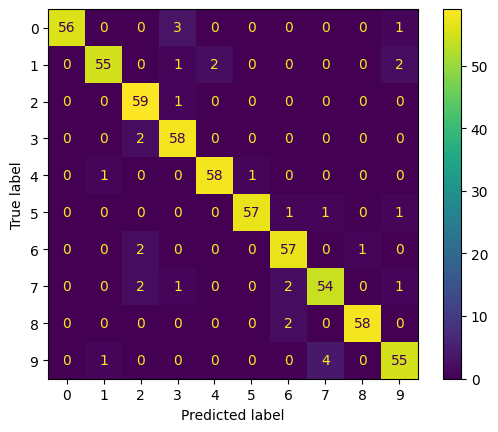

In [17]:
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

#confusion matrix
print('CONFUSION MATRIX _ RANDOM FOREST:')
#disp=plot_confusion_matrix(rf_random, X_test, y_test)
disp = ConfusionMatrixDisplay.from_estimator(rf_random, X_test, y_test)
plt.show()

In [18]:
#classification report
print('CLASSIFICATION REPORT _ RANDOM FOREST:\n\n',classification_report(y_test,predicted))
print('Accuracy:\n',accuracy_score(y_test, predicted))

CLASSIFICATION REPORT _ RANDOM FOREST:

               precision    recall  f1-score   support

           0       1.00      0.93      0.97        60
           1       0.96      0.92      0.94        60
           2       0.91      0.98      0.94        60
           3       0.91      0.97      0.94        60
           4       0.97      0.97      0.97        60
           5       0.98      0.95      0.97        60
           6       0.92      0.95      0.93        60
           7       0.92      0.90      0.91        60
           8       0.98      0.97      0.97        60
           9       0.92      0.92      0.92        60

    accuracy                           0.94       600
   macro avg       0.95      0.94      0.95       600
weighted avg       0.95      0.94      0.95       600

Accuracy:
 0.945


In [19]:
# check of the probabilities for a random sample
print("The label for this sample in y_test is {}".format((y_test)[60]))
print("The random forest predicted for it {}".format((predicted[60])))
a = rf_random.predict_proba(X_test)
print("Each class got these probabilities: {}".format(a[60]))

The label for this sample in y_test is 8
The random forest predicted for it 8
Each class got these probabilities: [0.0275     0.00333333 0.0075     0.03333333 0.00166667 0.00333333
 0.0575     0.00333333 0.86083333 0.00166667]
